# CH4 Time Series Preprocessing  
**Purpose**: Prepare methane (CH4) data for forecasting using `GasPreprocessor`  

## Workflow  
1. Load cleaned GHG data  
2. Initialize preprocessor  
3. Fit/transform CH4 series  
4. Save processed data  

**Input**: `data/processed/all_ghg_aligned_nan.csv`  
**Output**: `data/processed/ch4_preprocessed.csv`  

[View GasPreprocessor docs](../src/preprocessing.py)  

**Note**: The identical preprocessing will be reapplied to the training set in `4_ch4_modeling.ipynb`  
to avoid data leakage. This full-dataset version is for exploratory purposes only.

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.preprocessing import GasPreprocessor
print('GasPreprocessor imported sucessfully!')

GasPreprocessor imported sucessfully!


# Load datasets

In [3]:
# load cleaned data (with negative values --> NaN)
df = pd.read_csv(
    '../data/processed/all_ghg_aligned_nan.csv',
    parse_dates=['date'],
    dtype={'CH4': float}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 2562 records


,date,CH4,CO,CO2,H2,N2O,SF6
0,1969-08-20,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-08-27,NaN,NaN,NaN,NaN,NaN,NaN
2,1969-09-02,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-09-12,NaN,NaN,320.945,NaN,NaN,NaN
4,1969-09-24,NaN,NaN,320.890,NaN,NaN,NaN


In [4]:
# Check input data before calling fit_transform
print(f"Input data shape: {df[['date', 'CH4']].shape}")
print(f"NaN values in CH4: {df['CH4'].isna().sum()}")
print(f"Negative values in CH4: {(df['CH4'] < 0).sum()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Input data shape: (2562, 2)
NaN values in CH4: 432
Negative values in CH4: 0
Date range: 1969-08-20 00:00:00 to 2025-04-03 00:00:00


# Initialize Preprocessor class

In [5]:
# configure for weekly CH4 data with yearly seasonality
preprocessor = GasPreprocessor(
    gas_name='CH4',
    do_eda=True,
    iqr_factor=3.0
)

## CH4 Preprocessing and EDA


[INFO] Fitting preprocessing for CH4
Data collection start date for CH4: 1983-05-06 00:00:00
Raw data: 2562 points, 432 NaNs
Trimmed data: 2174 points, 44 NaNs
After resampling: 2188 points, 84 NaNs
[INFO] Found 43 potential outliers using robust STL residuals.
After outlier removal: 2188 points, 127 NaNs
After smoothing: 2188 points, 0 NaNs
After interpolation: 2188 points, 0 NaNs


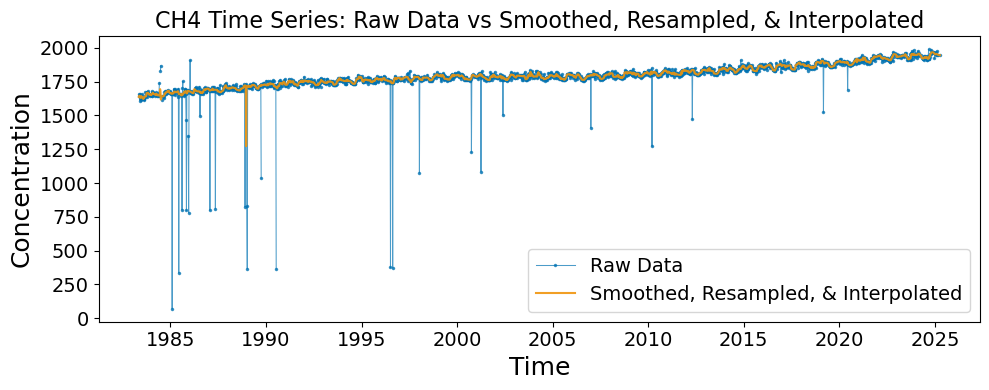

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.8819
ADF p-value 0.7939
ADF critical values: {'1%': -3.4333740509447717, '5%': -2.8628759187993382, '10%': -2.567481176655697}

KPSS statistic 6.9576
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


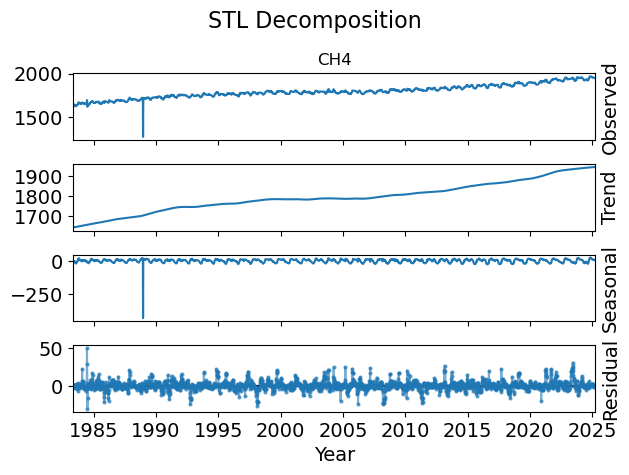

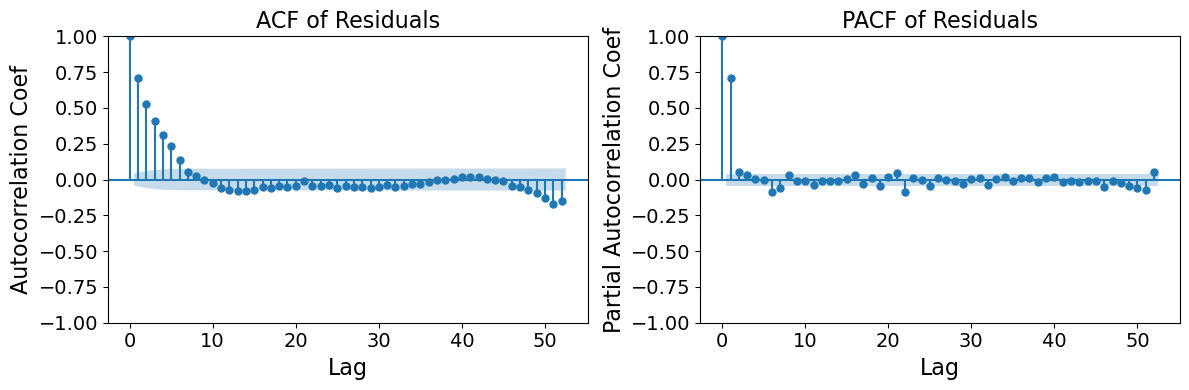


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.7166
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.6355
No heteroscedasticity detected (White test)


date
1983-05-08    1629.48850
1983-05-15    1637.32925
1983-05-22    1637.32925
1983-05-29    1629.48850
1983-06-05    1630.24525
Freq: W-SUN, Name: CH4, dtype: float64

In [19]:
# CH4_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True)
# CH4_preprocessed = CH4_preprocessor.fit_transform(df_combined)

# Run full preprocessing pipeline
ch4_preprocessed = preprocessor.fit_transform(
    df[['date', 'CH4']],
    custom_title='CH4 Time Series: Raw Data vs Smoothed, Resampled, & Interpolated')

# Show results
display(ch4_preprocessed.head())
plt.show()

## CH4 Preprocessing Results Summary

### **Preprocessing**
The preprocessing pipeline successfully handled outliers and missing (NaN) values while remaining consistent with the original time series characteristics.  

### **Stationarity Analysis**
All processing stages (raw --> smoothed --> resampled) show consistent non-stationarity:
- **ADF Test**: Fails to reject H0 (p > 0.05)  
- **KPSS Test**: Rejects H0 (p < 0.05)  
*Interpretation*: Strong trend dominance persists through preprocessing, which is expected and appropriate.  Differencing to achieve stationarity will be handled during SARIMA model specification.  

### **STL Decomposition Insights**
Analysis of the STL decomposition residuals indicates homoscedastic variance:
- **Breusch-Pagan test**: No heteroscedasticity detected (p = 0.72)
- **White test**: No heteroscedasticity detected (p = 0.64)
  
Constant variance in residuals is an optimal characteristic for SARIMA modeling.  
  
### **Autocorrelation Diagnostics**
- **ACF of Residuals**:  
  - Slow decay in ACF suggests an autoregressive (AR) component 
  - Significant lags at 1-5, potentially indicating an MA(5) process (MA = moving average)  
  - Spike at lag 52 suggests residual seasonality that may require seasonal AR or MA terms
- **PACF of Residuals**:  
  - Sharp cutoff after lag 1 suggests a strong AR(1) process 

### **Key Implications for Modeling**
1. Required transformations:  
   - **Differencing**: First order differencing will be necessary to address persistent (upward) trend
   - **Seasonal adjustment**: Seasonal terms (likely period 52) should be incorporated to capture remaining seasonal pattern
2. Initial model specification:  
   - ARIMA(1,1,5) as starting point  
   - Seasonal periodicity: 52 weeks  
3. Variance stability:
   - The homoscedastic residuals suggest that variance-stabilizing transformations may not be necessary

# Save Preprocessed CH4 Data

In [7]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save metadata
output_path = output_dir / 'ch4_preprocessed.csv'
(
    ch4_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4 preprocessed data saved to:\n{output_path}')
print(f'Shape: {ch4_preprocessed.shape}\nLast 5 records:')
display(ch4_preprocessed.tail())

CH4 preprocessed data saved to:
..\data\processed\ch4_preprocessed.csv
Shape: (2188,)
Last 5 records:


date
2025-03-09    1948.7200
2025-03-16    1946.7475
2025-03-23    1946.7475
2025-03-30    1945.6850
2025-04-06    1945.6850
Freq: W-SUN, Name: CH4, dtype: float64